# Data Storytelling with the Boston Earnings Datasets

This notebook will attempt to show a few interesting insights into the Boston earnings datasets that have been published annually since 2011. Each dataset lists employee name, job title, department and zip code, along with earnings broken down into the categories "Regular", "Retro", "Other", "Overtime", "Injured", "Detail", "Quinn" and the "Total" of the numerical entries.

First let's import the necessary modules for analysis.

In [1]:
# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib notebook

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate

# map functions
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
osm_tiles = OSM()

# ordinary least squares
from statsmodels.formula.api import ols

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

### Read the combined data file

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


### Overview

First, let's have a look at some general numbers. 

<IPython.core.display.Javascript object>


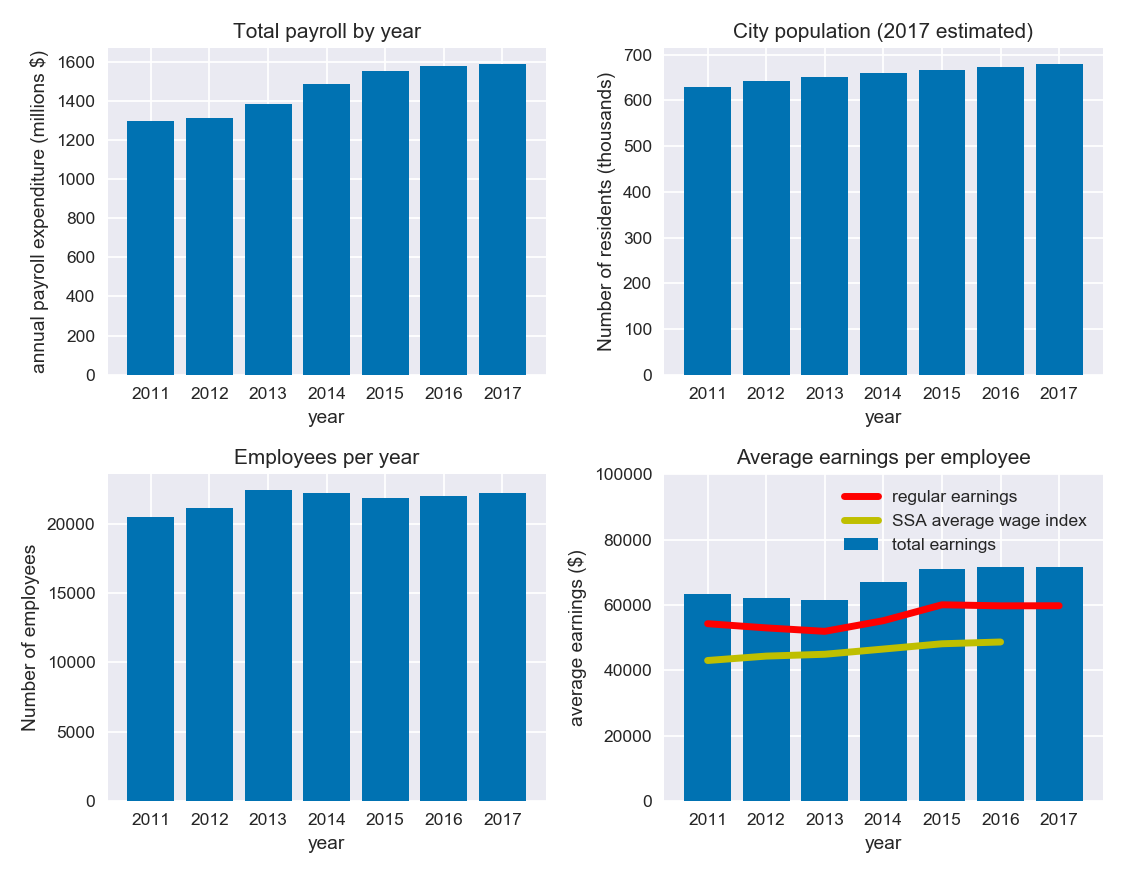

In [3]:
# total payroll by year
total_payroll = earnings.groupby(earnings['year'])[['regular', 'total', 'name']]\
                        .agg({'regular': np.sum, 'total': np.sum, 'name': 'count'})\
                        .reset_index()\
                        .set_index('year')
total_payroll['epc'] = total_payroll['total'] / total_payroll['name'] # average total earnings per capita
total_payroll['rpc'] = total_payroll['regular'] / total_payroll['name'] # average regular earnings per capita
total_payroll = total_payroll.reset_index()

""" 
Average wage index (AWI) for the United States
Source: https://www.ssa.gov/oact/cola/awidevelop.html
"""
total_payroll['awi'] = pd.Series([42979.61, 44321.67, 44888.16, 46481.52, 48098.63, 48642.15]) # AWI, years 2011-2016

"""
City of Boston population estimates
https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045216
2017 data is extrapolated from 2011-2016 data
"""
year_actual, pop_actual = np.array([2011, 2012, 2013, 2014, 2015, 2016]), \
                        np.array([630195, 641911, 651090, 659180, 665984, 673184])
f = interpolate.interp1d(year_actual, pop_actual, fill_value='extrapolate')
population = np.append(pop_actual, f(2017))

# create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,7))

x = total_payroll['year']

# Total payroll by year
ax1.bar(x, total_payroll['total']/1000000)
ax1.set_xlabel('year')
ax1.set_ylabel('annual payroll expenditure (millions $)')
ax1.set_title('Total payroll by year')

# City population
ax2.bar(x, population/1000)
ax2.set_xlabel('year')
ax2.set_ylabel('Number of residents (thousands)')
ax2.set_title('City population (2017 estimated)')

# Employees per year
ax3.bar(x, total_payroll['name'])
ax3.set_xlabel('year')
ax3.set_ylabel('Number of employees')
ax3.set_title('Employees per year')

# Average earnings per employee
ax4.bar(x, total_payroll['epc'])
ax4.plot(x, total_payroll['rpc'], alpha=1, color='r', linewidth=4)
ax4.plot(x, total_payroll['awi'], color='y', linewidth=4)
ax4.set_xlabel('year')
ax4.set_ylabel('average earnings ($)')
ax4.set_title('Average earnings per employee')
ax4.legend(['regular earnings', 'SSA average wage index', 'total earnings'])
ax4.set_ylim(0, 100000)

plt.tight_layout()
plt.savefig('test.png', dpi=300)
plt.show()

Total payroll by year shows a gradual increase over the years with the slowest growth between 2011 and 2012 or 2016 and 2017. The largest jump in payroll expense occured in 2014. 

By comparison, the city population grew more steadily. The population data is based on census estimates and thus year-to-year growth fluctuations would be hard to detect. To confirm that population growth is not correlated to payroll expense, we can plot the number of employees per year. Here we see a noticeable increase in employees from 2011 to 2013. Given the modest increase in total payroll, it is likely the new jobs are low-paying or part-time jobs. 

In 2014, payroll rose significantly, but the number of employees actually decreased slightly. This can only be explained by significant pay increase per employee. In the final chart we see steady decline in pay per employee between 2011 and 2013. This doesn't necessarily mean that employees are taking a pay cut. It is possible that non-regular pay such as over time is reduced, or higher paying jobs are being replaced by lower paying jobs. 

From 2015 to 2017 total payroll, number of employees and earnings per employee begin to level off with little growth.

In [4]:
"""
There are more than one thousand unique job titles for less than 20,000 employees in the city of Boston earnings database. 
Any meaningful classification of job titles will need to be limited. 

Likewise, of the more than 50 departments, some have only a handful of employees. For classification purposes the dataset
will be limited to the top 10 titles and departments.
"""
# get top 10 titles by number of employees
titles_top10 = earnings\
                .groupby('title_clean')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]

# get top 10 departments by number of employees

departments_top10 = earnings\
                .groupby('dept_clean')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]
print(titles_top10)
print(departments_top10)

Index(['Teacher', 'Police Officer', 'Paraprofessional', 'Fire Fighter', 'Substitute Teacher', 'Lunch Hour Monitors', 'Part-Time Cafeteria Attendant', 'Cab Monitor', 'Police Detective', 'Police Sergeant'], dtype='object', name='title_clean')
Index(['Boston Public Schools', 'Boston Police Department', 'Boston Fire Department', 'Boston Cntr - Youth & Families', 'Boston Public Library', 'Public Works Department', 'Traffic Division', 'Parks Department', 'Inspectional Services Dept', 'Public Facilities Department'], dtype='object', name='dept_clean')


<IPython.core.display.Javascript object>


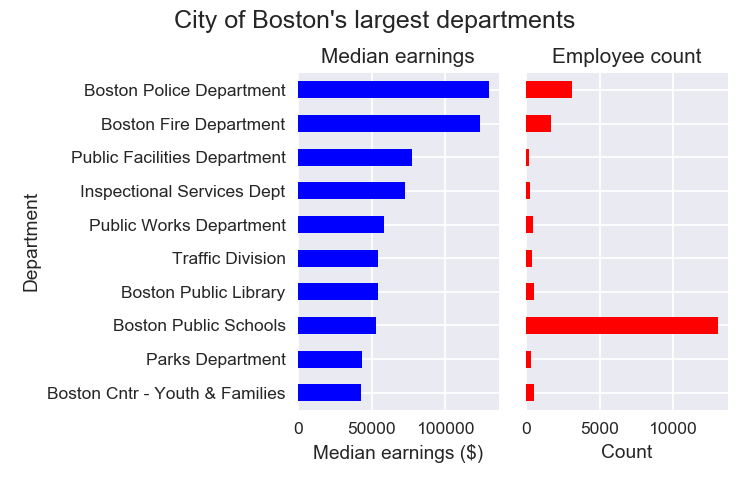

In [5]:
# Median earnings by department for 2017. Small departments are excluded for better statistics.
large_depts = earnings[(earnings['year'] == 2017)\
                       & (earnings['dept_clean'].isin(departments_top10))]\
                    [['total', 'dept_clean']]\
                    .groupby('dept_clean')\
                    .agg([np.median, np.size])\
            
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4), sharey=True) 

large_depts = large_depts.sort_values(by=('total', 'median'), ascending=False)

large_depts[('total', 'median')].plot.barh(color='b', ax=ax1)
large_depts[('total', 'size')].plot.barh(color='r', ax=ax2).invert_yaxis()


plt.suptitle('City of Boston\'s largest departments')
ax1.set_title('Median earnings')
ax1.set_ylabel('Department')
ax1.set_xlabel('Median earnings ($)')
ax2.set_title('Employee count')
ax2.set_xlabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The chart above shows the 10 largest departments by number of employees and their median total earnings. Over 92% of employees are working in the 10 largest departments, therefore the remaining departments will not have a significant impact on the analysis. In reference to the Pareto principle, we could limit the analysis to the police, fire and school departments since these three departments account for roughly 84% of the total payroll.

<IPython.core.display.Javascript object>


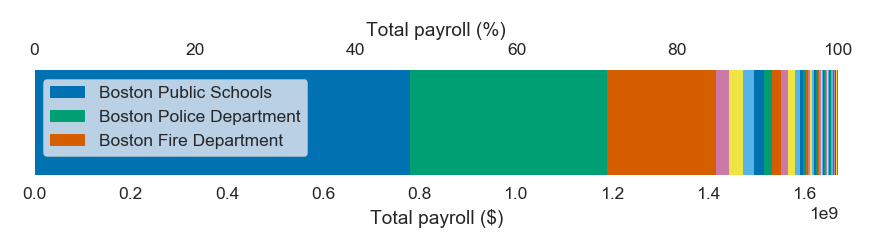

In [6]:
all_depts_sum = earnings[['total', 'dept_clean']]\
                [earnings['year'] == 2017]\
                .groupby('dept_clean')\
                .agg(np.sum)\
                .sort_values('total', ascending=False)
all_depts_sum['percent'] = all_depts_sum.total / all_depts_sum.total.sum() * 100

# generate horizontal stacked bar chart(s)
fig, ax1 = plt.subplots(figsize=(7,2))
ax2 = ax1.twiny()
all_depts_sum.drop('percent', axis=1).T.plot.barh(ax=ax1, width=1.0, stacked=True, legend=False, tick_label='')
all_depts_sum.drop('total', axis=1).T.plot.barh(ax=ax2, width=1.0, stacked=True, tick_label='')
ax1.set_ylim(0,0.41)
ax2.set_xlim(0,100)
ax2.grid(False)

# labels
ax1.set_xlabel('Total payroll ($)')
ax2.set_xlabel('Total payroll (%)')
ax1.set_ylabel('')
ax1.set_ylabel('')
# plt.legend(all_depts_sum.index[:3], frameon=True, bbox_to_anchor=(1.01, 1.05))
plt.legend(all_depts_sum.index[:3], frameon=True)
y_axis = ax2.axes.get_yaxis()
y_axis.set_ticks([])

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


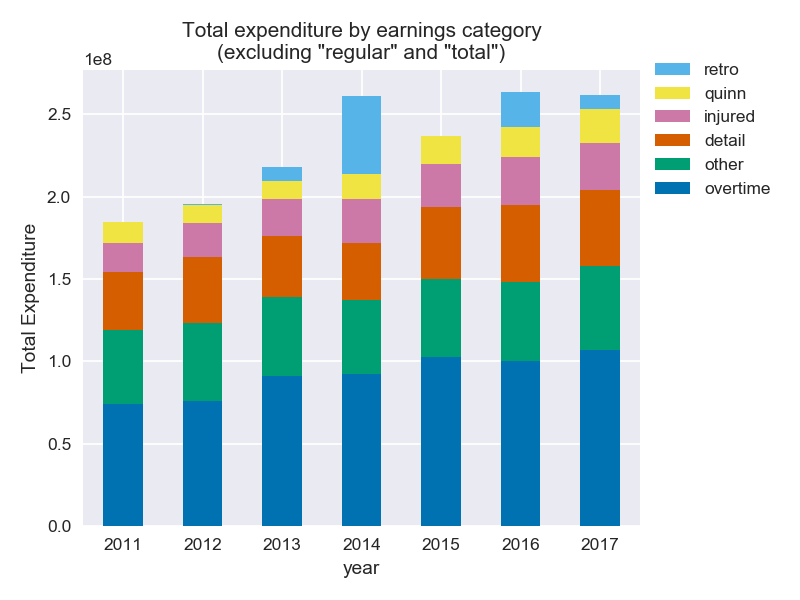

Overtime expenditure has increased by $33,141,220.42 since 2011


In [7]:
categories = earnings.groupby('year')\
                        .agg(np.sum)\
                        .drop(['regular', 'total'], axis=1)\
                        .sort_values(by=2011, ascending=False, axis=1)

# generate horizontal stacked bar chart(s)
fig, ax = plt.subplots()
categories.plot.bar(stacked=True, rot=0, ax=ax)
ax.set_title('Total expenditure by earnings category\n(excluding \"regular\" and \"total")')
ax.set_ylabel('Total Expenditure')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], prop={'size': 'small'},bbox_to_anchor=(1, 1.05))

plt.tight_layout()
plt.show()

ot = categories.loc[2017, 'overtime'] - categories.loc[2011, 'overtime']
print('Overtime expenditure has increased by ${:,.2f} since 2011'.format(ot))

Not counting ***regular*** and ***total***, ***overtime*** is the largest expenditure in the payroll budget. Since 2011 the number has increased by over $33 million. 

Also noteworthy is the significant increase in ***retro*** payments in 2014.

<IPython.core.display.Javascript object>


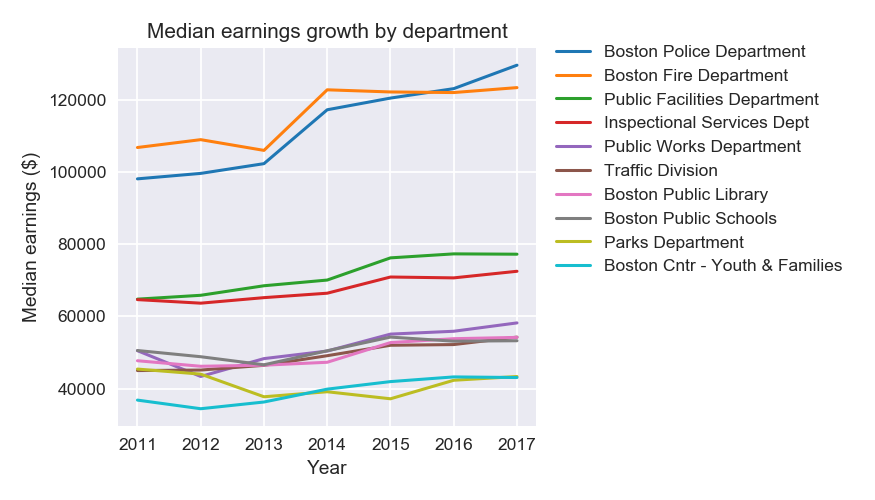

In [8]:
# plot earnings growth by department
ld = pd.pivot_table(earnings[earnings['dept_clean'].isin(departments_top10)], index='year', columns='dept_clean', values=['total'], aggfunc=np.median)
ld.columns = ld.columns.droplevel()
ld = ld.T.sort_values(by=2017, ascending=False).T

fig, ax = plt.subplots(figsize=(7,4))
ld.plot(cmap='tab10', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.05))
ax.set_title('Median earnings growth by department')
ax.set_ylabel('Median earnings ($)')
ax.set_xlabel('Year')
# ax.set_yscale('log')
plt.tight_layout()
plt.show()

Median total earnings by department show a general increase with exception of the parks department - possibly due to varying hours and number of seasonal employees.

An interesting observation is the jump in 2014 seen for the police and fire departments.

### Growth rate data analysis

Unfortunately the datasets do not provide key information needed to assess pay increases per employee. We are missing start date, termination date, promotion date, annual or hourly pay and full or part time status.

In order to estimate or approximate the lack missing information, we can arbitrarily define a full time job as earning more than $40,000 in regular pay per year. An earnings growth cap of 22\% per year will help filter out data from employees who started mid-year and whose pay does not reflect what they would have earned for a full year. Lastly, negative growth indicates mid-year employment end, whether through retirement, termination or other reasons.

Promotions can be viewed as a change in job title, although this is not always reliable due to job title changes for otherwise identical positions.

These data corrections will significantly reduce the error on the analysis.

Growth is calculated as "compound annual growth rate" or "CAGR".

In [9]:
"""
compound annual growth rate

1. An arbitrary limit is set on "first" since low earnings are often not full time positions
2. An arbitrary cap on the growth rate result is needed for new hires whose first year earnings are not a full year
3. Negative growth is not allowed (part-time, retirement, resignation, termination, etc.)
"""

def cagr(first, last, periods=1): 
    if (first < 40000):
        return np.nan
    x = ((last/first) ** (1/periods) - 1 ) * 100
    if ((x > 22) & (periods == 1)) | (x < 0) : 
        return np.nan
    return x

In [10]:
# pivot earnings data to show annual earnings by name:
growth = pd.pivot_table(earnings, columns='year', index=['name'], values='regular')\
                    .reset_index()\
                    .apply(pd.to_numeric, errors='ignore')

# calculate CAGR for all available years:
years = (earnings.year.unique())
for previous, following in zip(years, years[1:]):
    growth['yoy' + str(following)] = growth.apply(lambda x: cagr(x[previous], x[following]), axis=1)

# drop names with no qualified CAGR entries:
c = growth.iloc[0:, -(len(years)-1):].columns
growth = growth.dropna(subset=c, how='all')

# merge with 'titles_clean' (both first and last) and 'dept_clean' (only the most recent):
titles = earnings.groupby('name')[['title_clean', 'dept_clean']]\
                 .agg({'title_clean':['first', 'last'], 'dept_clean':'last'})\
                 .reset_index()

# avoid multiindex issues:
titles.columns = ['_'.join(tup).rstrip('_') for tup in titles.columns.values]

# merge dataframes:
growth_title = growth.merge(titles, how='left', on='name')

# calculate compound annual growth rate for all available years:

growth_title['cagr_all'] = growth_title.apply(lambda y: cagr(y[2011], y[2011+len(years)-1], len(years)-1), axis=1)
print(growth_title.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16221 entries, 0 to 16220
Data columns (total 18 columns):
name                 16221 non-null object
2011                 13163 non-null float64
2012                 13933 non-null float64
2013                 14721 non-null float64
2014                 15177 non-null float64
2015                 15051 non-null float64
2016                 14407 non-null float64
2017                 13698 non-null float64
yoy2012              8873 non-null float64
yoy2013              9584 non-null float64
yoy2014              10287 non-null float64
yoy2015              10778 non-null float64
yoy2016              7639 non-null float64
yoy2017              8301 non-null float64
title_clean_first    16221 non-null object
title_clean_last     16221 non-null object
dept_clean_last      16221 non-null object
cagr_all             8106 non-null float64
dtypes: float64(14), object(4)
memory usage: 2.4+ MB
None


Note that NaNs are not filled at this point since a numeric fill value would change the calculations below.

Growth rates are aggregated based on valid growth rates only. Pandas would ordinarily aggregate indiscriminantly over valid and invalid data, so we have to use a different approach.

Mean in the following data is simply defined as a mean across the row or column data. The individual CAGR numbers and the "cagr_all" column are weighted according to the number of valid entries.

<IPython.core.display.Javascript object>


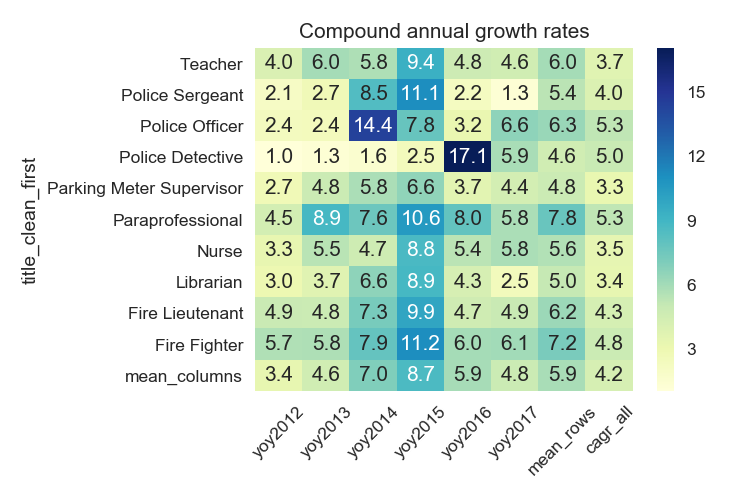

In [11]:
# get top 10 job titles by number of employees where no promotion (title change) occured.

growth_titles_top10 = growth_title[growth_title['title_clean_first'] == growth_title['title_clean_last']]\
                .groupby('title_clean_first')\
                .agg('size')\
                .nlargest(10)\
                .index

# keep only growth rate columns ('yoy...') and top 10 title rows
payraise = growth_title.iloc[:, len(years)+1:(len(years)*2)+1]
payraise = payraise[payraise['title_clean_first'].isin(growth_titles_top10)]

# calculate means and mean of means
payraise = payraise.set_index('title_clean_first')
payraise['mean_rows'] = payraise.stack().groupby(level=0).mean()
payraise  = payraise.groupby(payraise.index).agg('mean')
payraise = payraise[::-1]

# append all years cagr:
cagr_all = growth_title[['title_clean_first', 'cagr_all']]
cagr_all = cagr_all.groupby('title_clean_first')[['title_clean_first', 'cagr_all']].agg('mean')
payraise = payraise.merge(cagr_all, how='left', left_index=True, right_index=True)
payraise.loc['mean_columns'] = payraise.mean()

# plot heatmap
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(payraise, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax)
ax.set_xticklabels(payraise.columns,rotation=45)
ax.set_title('Compound annual growth rates')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


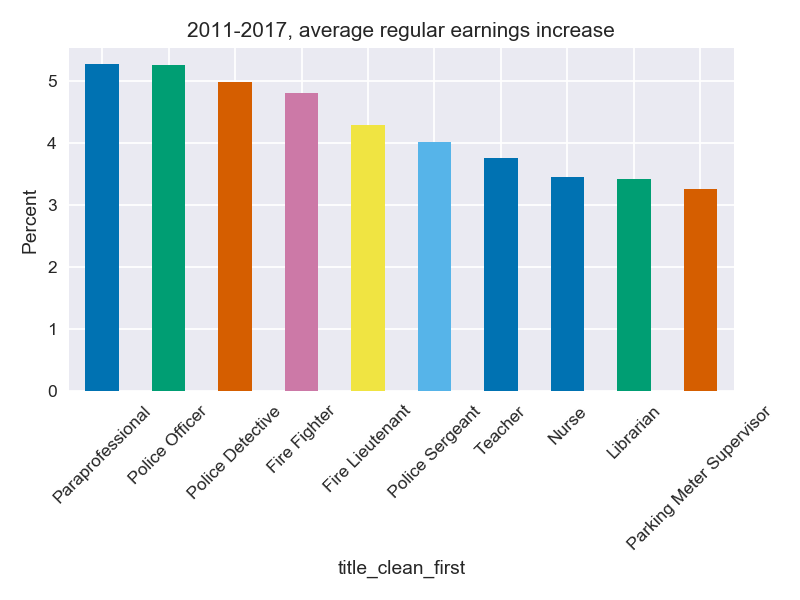

In [12]:
# pay raises by year

 
# plot

# ax1 = payraise.drop('mean_columns')\
#                 .drop(columns=['mean_rows', 'cagr_all'])\
#                 .T\
#                 .plot(xticks=[0,1,2,3,4,5], cmap='tab10')
# ax1.set_ylabel('Percent')
# ax1.set_title('YOY regular earnings increase')

# pay raises - all years
plt.figure()
ax2 = payraise.drop('mean_columns')\
            .sort_values('cagr_all', ascending=False)\
            .iloc[:,-1]\
            .T\
            .plot(kind='bar', xticks=[0,1,2,3,4,5], rot=45)
ax2.set_ylabel('Percent')
ax2.set_title('2011-2017, average regular earnings increase')
plt.tight_layout()
plt.show()


The most interesting observation from these charts are the two spikes in regular earnings growth rates, 14.4% for police officers in 2014 and 17.1% for police detectives in 2016. While this may seem at first very generous, it was preceded by several years of virtually no regular earnings increases. In the end, the average growth rate is about 5% annually for both job titles, which is only slightly higher than most other job titles. More years of earnings data would be needed to fully evaluate this.

The only job title with a higher average regular earnings growth rate is "Paraprofessional". Paraprofessional is typically not a steady, full time career. This will make the growth rate artificially high.  

These charts also explain an earlier observation about significant increase in earnings per employee in 2014. We can speculate that police earnings were relatively flat until the unions negotiated a pay increase to bring their earnings increases more or less in line with other job titles.


<IPython.core.display.Javascript object>


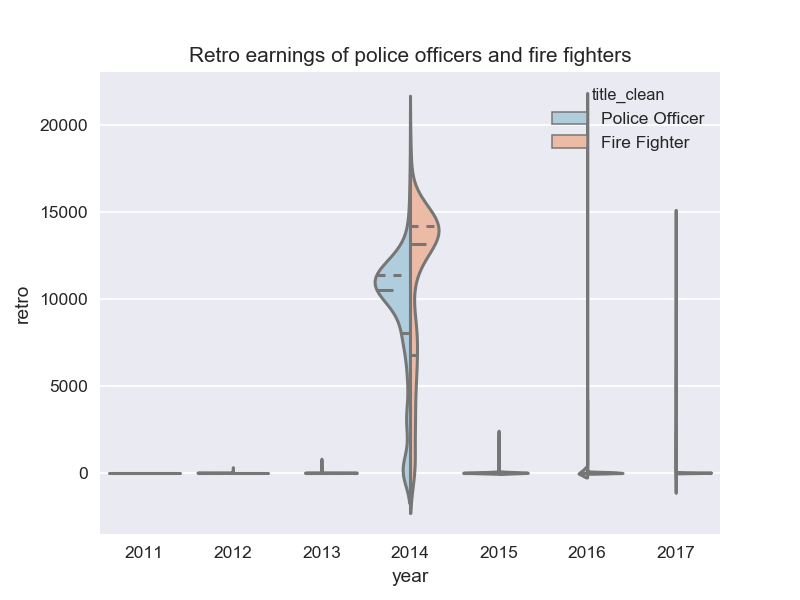

In [13]:
# Retro earnings in 2014

retro = earnings[earnings['title_clean'].isin(['Police Officer','Fire Fighter'])]

fig, ax = plt.subplots()
sns.violinplot(x='year', y='retro', hue='title_clean', data=retro, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
ax.set_title('Retro earnings of police officers and fire fighters')
plt.show()

Now we can see that the large payroll increase in 2014 was due in part to regular earnings increases for police officers, and also due to significant "retro" payments for police and fire fighters. Since the earnings categories are not explained, we need to once again speculate that retro payments are negotiated back pay for earnings not realized during the union negotiation period.

### Data correlation

Can we observe correlations between any of the earnings categories? The "total" category is omitted here since it is the sum of the other categories. "Quinn" is also omitted since it is a category specific to the police department.

For better visibility we'll extract only the top 10 most common job titles.

<IPython.core.display.Javascript object>


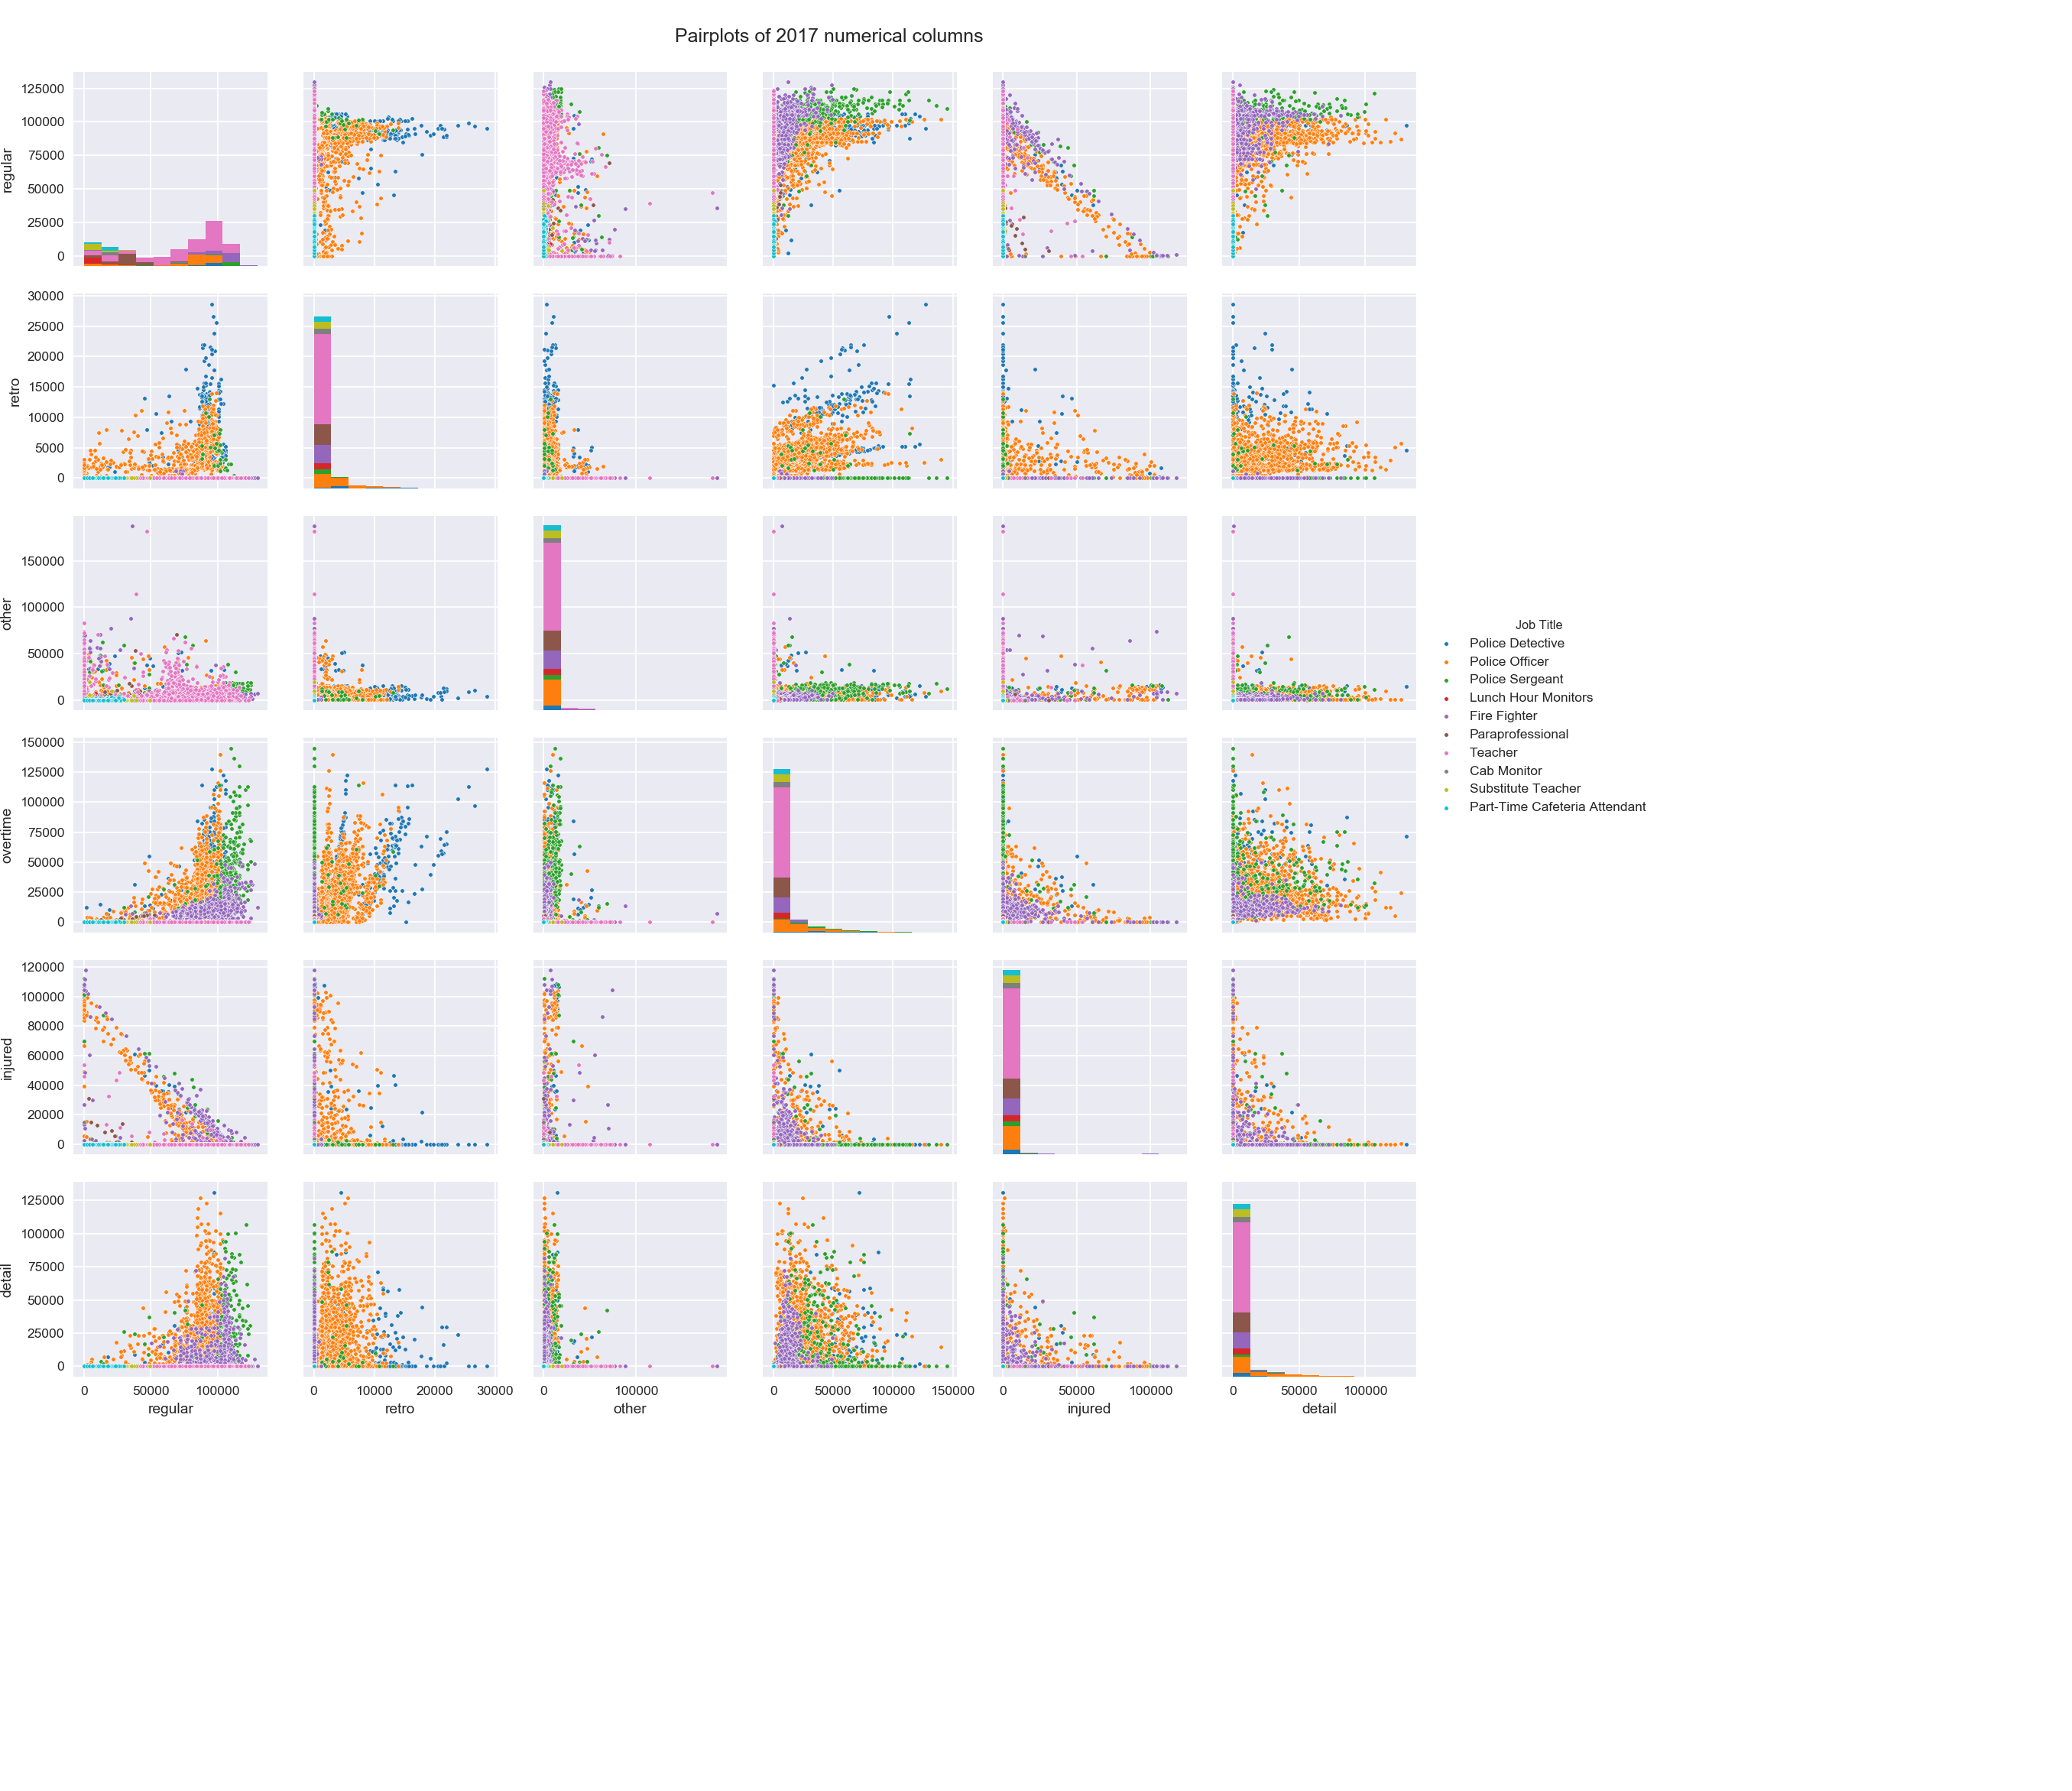

In [14]:
# extract 10 most common job titles
titles = earnings[(earnings['title_clean'].isin(titles_top10)) & (earnings['year'] == 2017)] \
                .rename(index=str, columns={'title_clean': 'Job Title'})  # for plot legend

usecols = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail']

# plot
g = sns.pairplot(titles, hue='Job Title', vars=usecols, plot_kws={'s': 10, 'alpha': 1.0}, palette="tab10")
g.fig.suptitle('Pairplots of 2017 numerical columns')
g.fig.subplots_adjust(top=0.95)
plt.show()

The paired scatter plots above show the relationship between all of the numerical columns in the dataframe with exception of "Quinn" which is an education incentive specific to the police department, and "Total", which is the sum of the numerical columns. 

A few general observations follow:

- Police and fire fighters account for the bulk of ***retro***, ***other***, ***overtime***, ***injured*** and ***detail*** categories. 
- "Retro" payments are almost exclusive to the police department.
- "Overtime" is primarily for middle income employees. Salaried employees don't usually get overtime pay and lower income employees are not full time and therefore don't qualify for overtime.
- "Injured" appears to replace "regular" pay in many cases.
- "Detail" and "overtime" scatter plots have similar shapes and may possibly be alternative categories for similar compensation.

### Zip code data

Can we use the zip code information to plot something interesting?

In [15]:
"""
1. Obtain latitude and longitude data for US zip codes from
https://www.census.gov/geo/maps-data/data/gazetteer2017.html

2. Count number of employees by zip code

3. Perform inner merge to get complete sets 

4. Filter Boston zip codes from suburban zip codes.
"""
# zip code latitude and longitude data
zll = pd.read_csv('2017_Gaz_zcta_national.txt', sep='\t', encoding = "ISO-8859-1", usecols=[0, 5, 6], names=['zip', 'lat', 'long'], header=0, dtype={'zip': object})

# count employees per zip code
zip_count = earnings[earnings.year == 2017]\
                .groupby('zip')['name']\
                .agg(np.size)\
                .reset_index()\
                .rename(columns={'name': 'employees'})
zip_df = pd.merge(zip_count, zll, on='zip', how='inner')

# Read in Boston zipcode list
boston = pd.read_csv('boston-zipcodes.csv', names=['zip'], header=None, dtype={'zip': object})

# generate various zip code maps
boston = pd.merge(zip_df, boston, on='zip', how='inner')
suburbs = zip_df[~zip_df['zip'].isin(boston['zip'])]
              
# by income level 
rich = earnings[(earnings['year'] == 2017) & (earnings['total'] >= 81500)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
poor = earnings[(earnings['year'] == 2017) & (earnings['total'] < 81500) & (earnings['total'] >= 19917)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
rich = rich.merge(zll, on='zip', how='left')
poor = poor.merge(zll, on='zip', how='left')

# normalize "rich" employee count to match "poor":
print(rich.employees.sum(), poor.employees.sum())

9050 9050


<IPython.core.display.Javascript object>


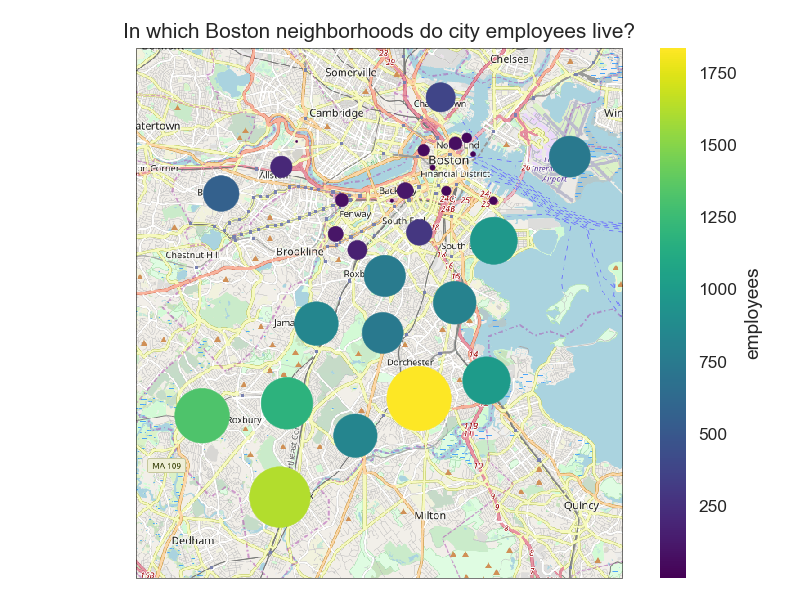

In [16]:
fig = plt.figure()
ax = plt.axes(projection=osm_tiles.crs)

# define map range (city of Boston)
img_extent = (-71.19, -70.985, 42.395, 42.23)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image
ax.add_image(osm_tiles, 12)

# boston data
boston.plot('long','lat', kind='scatter', marker='.', s=boston['employees'].values*3, c='employees', cmap=plt.cm.viridis, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which Boston neighborhoods do city employees live?')
plt.tight_layout()
plt.show()

The map above shows that the majority of employees live in residential neighborhoods and the most popular zip code is the Ashmont neighborhood of Dorchester, followed by Hyde Park.

<IPython.core.display.Javascript object>


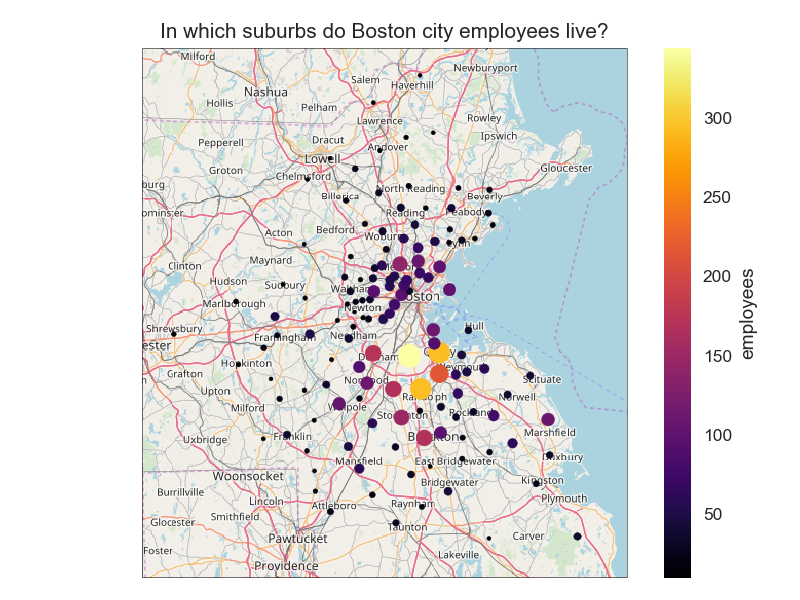

In [17]:
# map image from open street maps

fig = plt.figure()
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# suburban zip codes with at least 10 employees
suburbs_min10 = suburbs[suburbs['employees'] > 9]
suburbs_min10.plot('long','lat', kind='scatter', marker='.', s=suburbs_min10['employees'].values * 2, c='employees', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which suburbs do Boston city employees live?')

plt.tight_layout()
# plt.savefig('suburbs.png')
plt.show()

A surprising result of the suburbs plot is that the majority of suburban employees live in the southern suburbs. 

<IPython.core.display.Javascript object>


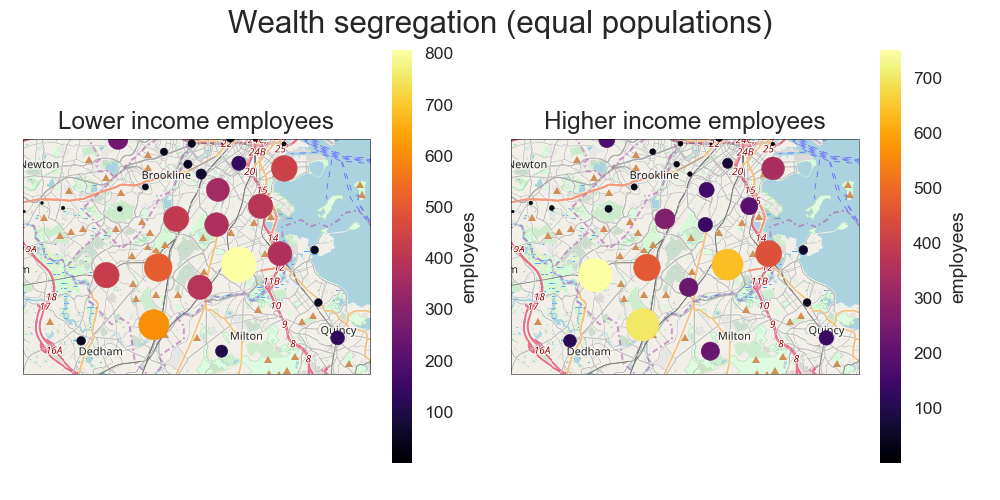

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': osm_tiles.crs}, figsize=(8, 4))

# define map range
img_extent = (-71.22, -70.98, 42.35, 42.23)
ax1.set_extent(img_extent, ccrs.PlateCarree())
ax2.set_extent(img_extent, ccrs.PlateCarree())

# # add map image, state lines
ax1.add_image(osm_tiles, 11)
ax2.add_image(osm_tiles, 11)

poor.plot('long','lat', kind='scatter', marker='.', s=poor['employees'].values*2, c='employees', cmap=plt.cm.inferno, ax=ax1, transform=ccrs.PlateCarree())
rich.plot('long','lat', kind='scatter', marker='.', s=rich['employees'].values*2, c='employees', cmap=plt.cm.inferno, ax=ax2, transform=ccrs.PlateCarree())

ax1.set_title('Lower income employees', fontsize=14)
ax2.set_title('Higher income employees', fontsize=14)
plt.suptitle('Wealth segregation (equal populations)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Here we can see wealth segregation particularly in the neighborhoods of Roxbury, Mattapan and Dorchester.

## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2017?

<IPython.core.display.Javascript object>


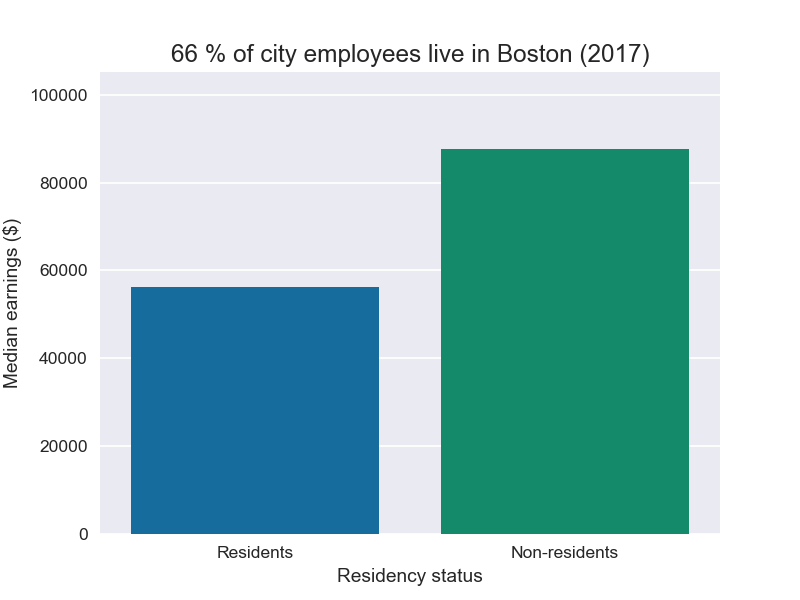

In [19]:
# Read in Boston zipcode list

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zip.isin(boston['zip']) & (earnings.year == 2017))]
outzips = earnings.loc[(~earnings.zip.isin(boston['zip']) & (earnings.year == 2017))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'Residency status': ['Residents', 'Non-residents'], 'Median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
plt.figure()
plt.title('%s %% of city employees live in Boston (2017)'%(int(residents)), fontsize=14)
sns.barplot(x='Residency status', y='Median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()

In [20]:
residents

66.70262980445044

From this chart we learn that almost two-thirds of the city employees live within city limits, but those who live in the suburbs are earning significantly more. Clearly higher earners have more protection through union contracts and other regulations to circumvent the residency requirement.